<a href="https://colab.research.google.com/github/stixmal/praktikum_project_ds/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5%20%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5/foto_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста покупателей

## 1. Исследовательский анализ данных

In [ ]:
# импорт библиотеки pandas и numpy
import pandas as pd 
import numpy as np  

# импорт модуля display
from IPython.display import display  

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотеки mathplot
import matplotlib.pyplot as plt 

# импорт ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# чтение файла с данными
df = pd.read_csv('/datasets/faces/labels.csv')

# визуальный осмотр  
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Пропуски в таблице отсутствуют, тип данных корректен. Неадекватных выбросов мы не наблюдаем - медиана достаточно близка к среднему в выборке.

***

Построим график распределения возраста в выборке.

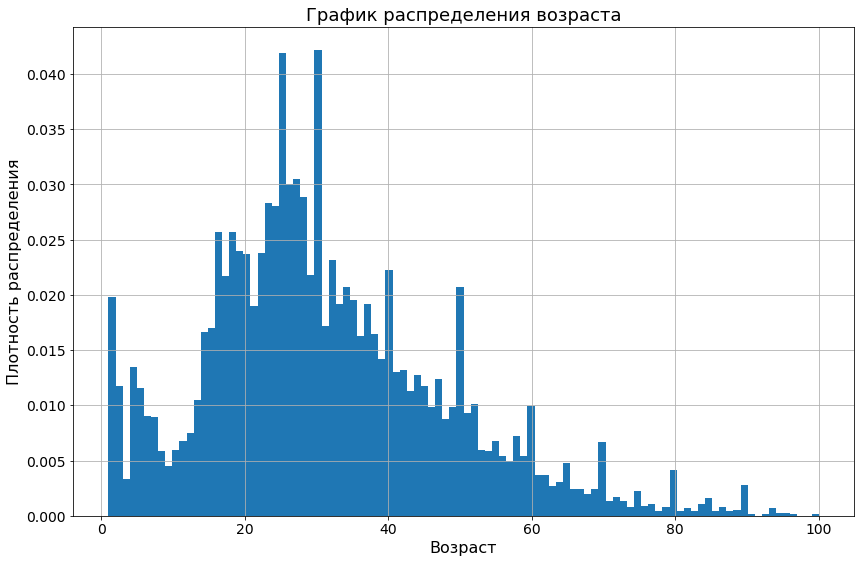

In [ ]:
# количество рейсов по моделям самолётов
plt.figure(figsize=(14, 9))
plt.title("График распределения возраста", fontsize=18) 
plt.xlabel("Возраст", fontsize=16) 
plt.ylabel("Плотность распределения", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.hist(df['real_age'], bins=100, density=True)
plt.show()

Изменили количество корзин на 100. Выделяются пики фотографий на рубежных возрастах: 30, 40, 50, 60, 70, 80. Возможно это связано с физиологическими изменениями во внешности, приходящимися на эти отметки, поэтому и требующие увеличенной выборки. Но данное утверждение требует проверки.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv('/datasets/faces/labels.csv'),
                                           directory=('/datasets/faces/final_files'),
                                           x_col='file_name', y_col='real_age', target_size=(224, 224), class_mode='raw')
features, target = next(datagen_flow)                                           

Found 7591 validated image filenames.


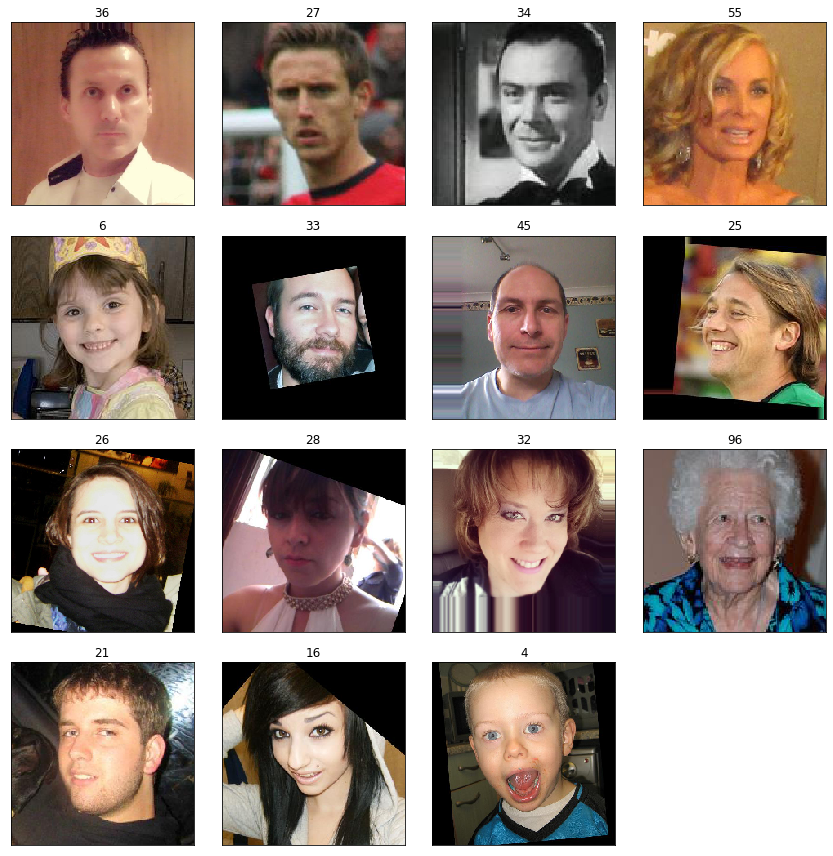

In [ ]:
# выводим 15 изображений
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

График распределения показывает, что имеется две пиковых плотности распределения фотографий по возрастам - дети до 10 лет и категория молодых 20-30 лет. Увеличенная категория фотографий людей с возрастом до 10 лет говорит о повышенном требовании к обучению модели, так как степень схожести фотографий детей гораздо больше схожести взрослых.

Добавили возраст к фотографиям. Размер фотографий мы взяли 224 на 224 пикселя, с отсутствием каких-либо поворотов и цветные. Большинство фотографий представлены анфасом или с небольшим поворотом головы.

## 2. Обучение модели

Код обучения модели ResNet50 представлен ниже.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
        
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    return train_gen_flow

def load_test(path):
        
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size, epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, 
          verbose=2, shuffle=True)
    
    return model 

```

Результаты вывода на экран.

```python

Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-03-29 04:09:14.867297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-29 04:09:15.173898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 48s - loss: 259.7915 - mae: 11.5219 - val_loss: 787.1952 - val_mae: 23.1372
Epoch 2/10
178/178 - 39s - loss: 61.5933 - mae: 5.9462 - val_loss: 812.5730 - val_mae: 23.5774
Epoch 3/10
178/178 - 39s - loss: 30.4322 - mae: 4.2589 - val_loss: 230.7267 - val_mae: 11.1418
Epoch 4/10
178/178 - 39s - loss: 18.6461 - mae: 3.3222 - val_loss: 103.4173 - val_mae: 7.8263
Epoch 5/10
178/178 - 39s - loss: 13.4224 - mae: 2.8405 - val_loss: 78.5931 - val_mae: 6.7823
Epoch 6/10
178/178 - 39s - loss: 10.6137 - mae: 2.5103 - val_loss: 67.2951 - val_mae: 6.2069
Epoch 7/10
178/178 - 39s - loss: 8.4514 - mae: 2.1994 - val_loss: 70.3752 - val_mae: 6.4902
Epoch 8/10
178/178 - 39s - loss: 7.6445 - mae: 2.0980 - val_loss: 77.4021 - val_mae: 6.5598
Epoch 9/10
178/178 - 39s - loss: 7.6483 - mae: 2.1038 - val_loss: 76.2988 - val_mae: 6.4975
Epoch 10/10
178/178 - 39s - loss: 7.4870 - mae: 2.0747 - val_loss: 66.0795 - val_mae: 6.2143
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 66.0795 - mae: 6.2143
Test MAE: 6.2143
```

## 3. Анализ обученной модели

В результате обучения нашей модели ResNet50 на 10 эпохах нам удалось добиться метрики MAE меньше 8 - Mean Absolute Error составляет 6.21 на тестовой выборке. Время обучения заняло менее 10 минут.  

Модель адекватно определяет возраст по фотографиям.

Выборка представлена 7591 фотографией. Мы разделили её на обучающую и тестовую в соотношении 75 на 25. Фотографии имеют размер 224 на 224 пикселя. В качестве модели мы взяли 50 слойную остаточную CNN ResNet50. Для обучения и оценки качества подавали обучающую и тестовую выборку батчами по 32 фотографии в количестве 10 эпох. В качестве функции потерь использовали MSE, а в качестве оценки MAE. Последний слой ResNet представлен одним нейроном с функцией активации 'relu'. Шаг обучения алгоритма Adam - 0.0001.  
    
В виду достаточной метрики качества MAE, укладывающейся в допустимый диапазон до 8, мы не применяли ни горизонтальный/вертикальный флип, повороты и растяжения к нашим выборкам.  

Полученная модель не совсем позволяет супермаркету «Хлеб-Соль» внедрить систему компьютерного зрения для обработки фотографий покупателей, в виду большого MAE. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
* Контролировать добросовестность кассиров при продаже алкоголя..